In [1]:
import sys
sys.path.append('.')

%load_ext autoreload
%autoreload 2

In [23]:
from collections import defaultdict

from IPython.display import Code, display
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import distributions as ptdist
from tqdm.auto import tqdm

from src.mm import mle
from src.mm import utils
from src.mm import vis

# MLE
## Coin tossing

### Data
First let's generate some coin tossing data according to a given distribution. Zeros should be interpreted as "tails" and ones as "heads".

In [3]:
def generate_coin_tossing_data(p, n_samples):
    possible_outcomes = [0, 1]
    data = np.random.choice(possible_outcomes, p=p, size=n_samples)
    return data


true_coin_probs = [0.3, 0.7]
num_samples = 700

coin_data = generate_coin_tossing_data(p=true_coin_probs, n_samples=num_samples)

### Model
Now we define our model and its parameters. We will use a Bernoulli distribution. Its parameters are the TAIL and HEAD probabilities. As we want to learn these probabilites we use `torch.nn.Parameter`, which automatically sets `requires_grad = True`. The likelihood function is defined as the `forward()` method, so that it takes observed data points (`data`) and returns the log of the probabilities for those data points.

In [4]:
class CoinTossingLikelihood(torch.nn.Module):
    """Likelihood model for coin tossing problem."""
    
    def __init__(self):
        """Inits CoinTosser."""
        super().__init__()
        self._probs = torch.nn.Parameter(torch.rand(size=(2,), dtype=torch.float))
        self.dist_cls = ptdist.Bernoulli

    @property
    def probs(self):
        return torch.nn.Softmax(dim=-1)(self._probs)
        
    def forward(self, data):
        """Computes the log probabilites for the given data points."""
        head_prob = self.probs[1]
        return self.dist_cls(probs=head_prob).log_prob(data)

### MLE
The code for calculating MLE is defined as follows:

In [5]:
display(Code(filename='src/mm/mle.py'))

"""Implementation of Maximum Likelihood Estimate."""
from typing import Dict, List, Union

import torch
from tqdm.auto import tqdm

from src.mm import vis


def run_mle(
    likelihood_model: torch.nn.Module,
    data: List[Union[int, List[int]]],
    num_epochs: int,
    lr: float,
    verbose=False,
) -> Dict[str, Union[List[float], Dict[str, List[float]]]]:
    """Implements Maximum Likelihood Estimation using gradient descent."""
    data = torch.tensor(data, dtype=torch.float)
    history = {
        'losses': [],
        'param_values': [],
    }

    optim = torch.optim.Adam(likelihood_model.parameters(), lr=lr)

    for _ in tqdm(range(num_epochs), disable=not verbose):
        # Zero gradients
        optim.zero_grad()

        # Compute predictions
        log_probs = likelihood_model(data)

        # Compute loss
        loss = -1 * torch.sum(log_probs)
        
        # Backpropagate
        loss.backward()
        optim.step()

        # Save values to log
        history['losses'].append(loss.item())

        mp = likelihood_model.probs
        history['param_values'].append(
            mp.item() if len(mp) == 1 else mp.tolist()
        )

    if verbose:
        vis.plot_losses_over_time(history['losses'])

    return history

Now let's use the above showed function:

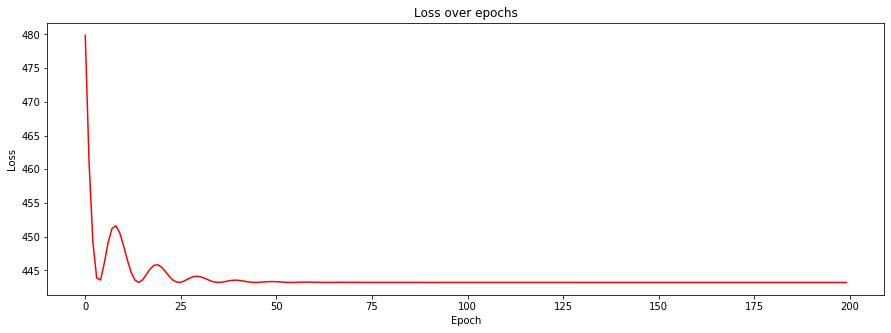

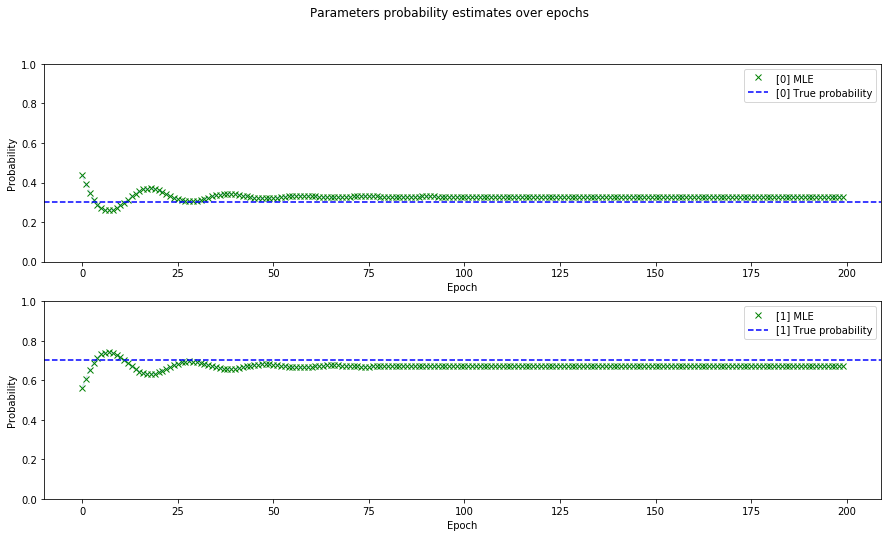

In [6]:
# MLE
num_epochs = 200

coin_model = CoinTossingLikelihood()

history = mle.run_mle(
    likelihood_model=coin_model,
    data=coin_data,
    num_epochs=num_epochs,
    lr=1e-1,
    verbose=True,
)

vis.plot_param_value_over_time(history['param_values'], true_coin_probs)

### MLE depending on data sample size

In [7]:
display(Code(filename='src/mm/utils.py'))

"""Utility functions for MLE."""
from tqdm.auto import tqdm

from src.mm import mle
from src.mm import vis


def plot_mle_estimate_given_sample_size(
    model_cls,
    data,
    true_prob,
    step,
    epochs_per_step
):
    """Runs MLE for given data sample sizes and plots results."""
    x = []
    mles = []

    for size in tqdm(range(1, len(data), step)):
        model = model_cls()

        mle.run_mle(
            likelihood_model=model,
            data=data[:size],
            num_epochs=epochs_per_step,
            lr=1e-1,
        )

        x.append(size)
        mp = model.probs
        mles.append(mp.item() if len(mp) == 1 else mp.tolist())

    vis.plot_param_value_over_time(
        mles,
        true_prob,
        x_vals=x,
        xlabel='Data sample size',
        title='MLEs for different sample sizes',
    )

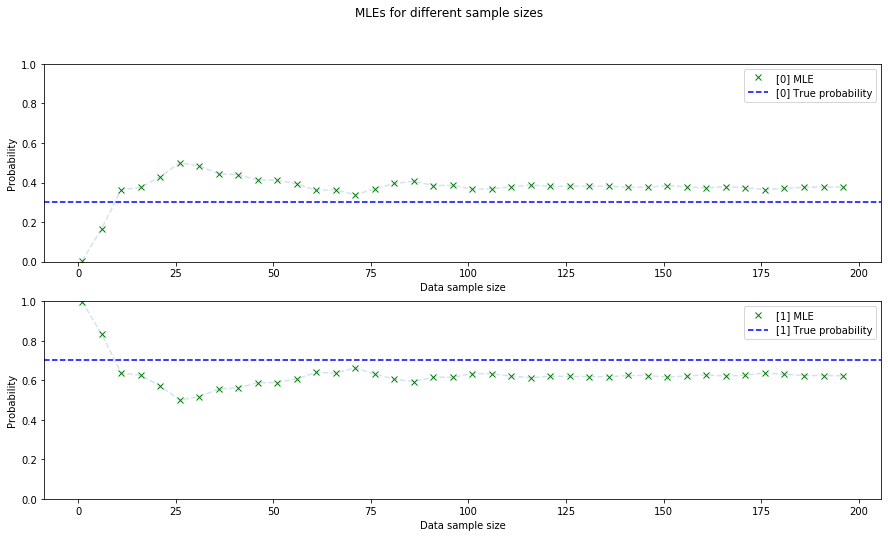

In [8]:
utils.plot_mle_estimate_given_sample_size(
    model_cls=CoinTossingLikelihood,
    data=coin_data[:200],
    true_prob=true_coin_probs,
    step=5,
    epochs_per_step=200,
)

### MLE - corner cases
What happens when we have many heads or tails at the beginning of the data?

1. Only tails at the beginning

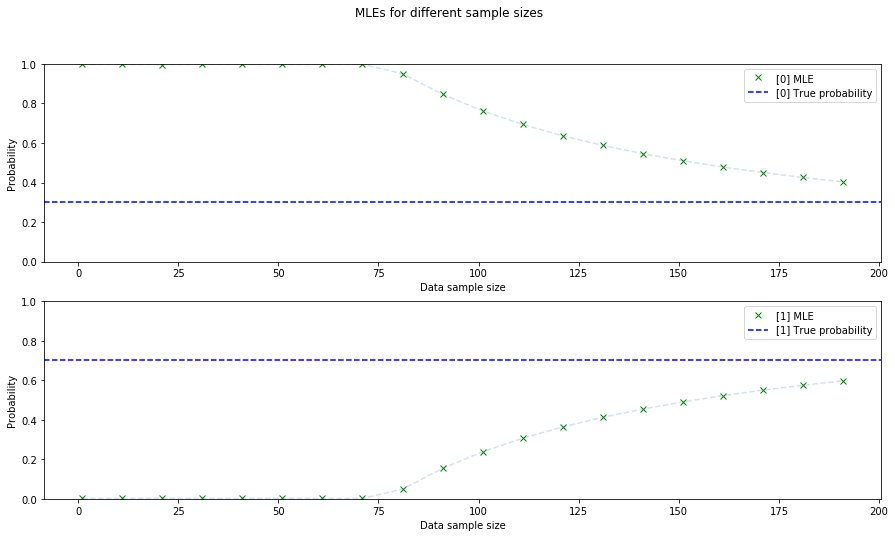

In [9]:
data_ascending = sorted(coin_data[:200])

utils.plot_mle_estimate_given_sample_size(
    model_cls=CoinTossingLikelihood,
    data=data_ascending,
    true_prob=true_coin_probs,
    step=10,
    epochs_per_step=200,
)

2. Only heads at the beginning

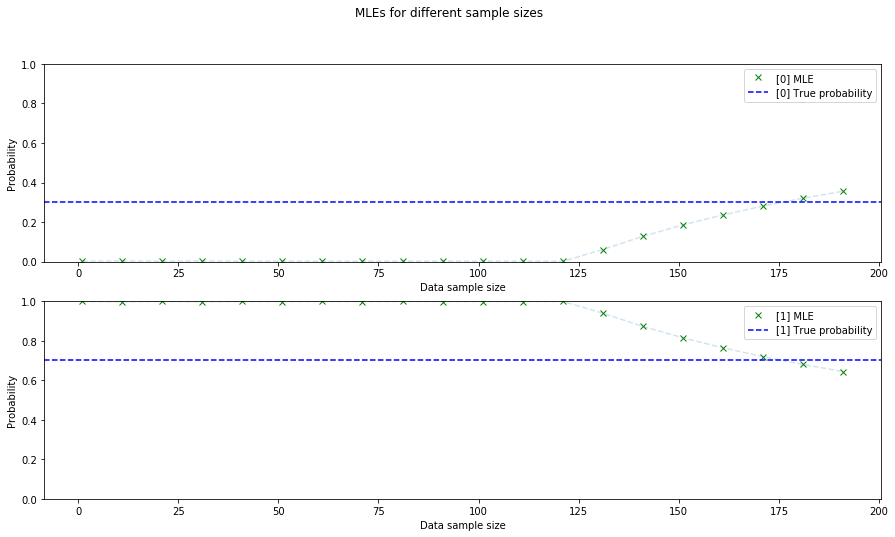

In [10]:
data_descending = list(reversed(data_ascending))

utils.plot_mle_estimate_given_sample_size(
    model_cls=CoinTossingLikelihood,
    data=data_descending,
    true_prob=true_coin_probs,
    step=10,
    epochs_per_step=200,
)

# Exercises

1. Using the above code example, implement MLE for a dice rolling problem:
    - generate data (single dice roll outcomes), pick the probabilities for each outcome (side)
    - each data sample should be encoded as a one-hot vector, e.g. 3 -> [0, 0, 1, 0, 0, 0]
    - pick an appropriate distribtion to define our likelihood function and initialize its parameters

In [11]:
def generate_dice_rolling_data(p, n_samples):
    possible_outcomes = np.array([
        [1.,0.,0.,0.,0.,0.], #1
        [0.,1.,0.,0.,0.,0.], #2
        [0.,0.,1.,0.,0.,0.], #3
        [0.,0.,0.,1.,0.,0.], #4
        [0.,0.,0.,0.,1.,0.], #5
        [0.,0.,0.,0.,0.,1.], #6
    ])
    indexes = np.random.choice(len(possible_outcomes),p=p,size=n_samples)
    data = []
    for index in indexes:
        data.append(possible_outcomes[index])
    #print(data)
    return torch.tensor(data)


true_sides_probs = [1/6,1/6,1/6,1/6,1/6,1/6] # fill with valid probs
print(true_sides_probs)

num_samples = 700
dice_data = generate_dice_rolling_data(p=true_sides_probs, n_samples=num_samples)
print(dice_data)

[0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
tensor([[0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.]], dtype=torch.float64)


In [12]:
# Model
class DiceRollingLikelihood(torch.nn.Module):
    def __init__(self, num_sides=6):
        super().__init__()
        self._probs = torch.nn.Parameter(torch.rand(size=(num_sides,), dtype=torch.float))
        self.dist_cls = ptdist.one_hot_categorical.OneHotCategorical
        
    @property
    def probs(self):
        return torch.nn.Softmax(dim=-1)(self._probs)
        
    def forward(self, data):
        return self.dist_cls(self.probs).log_prob(data)
 

C:\Studia\PUMA\l03-monday19-BlonskiP\src\mm\mle.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float)


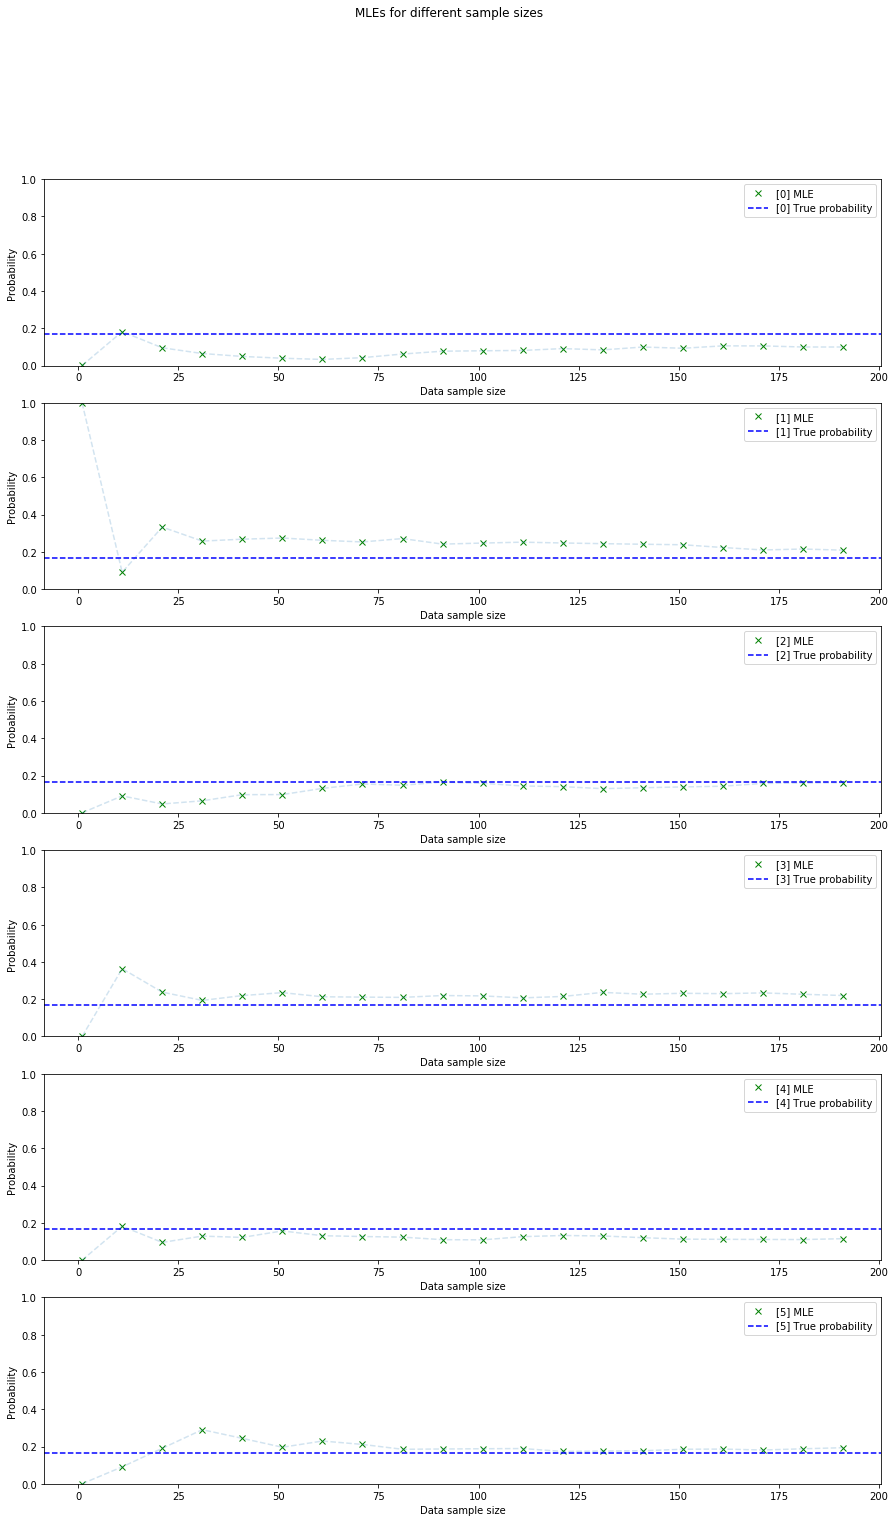

In [13]:
utils.plot_mle_estimate_given_sample_size(
    model_cls=DiceRollingLikelihood,
    data=dice_data[:200],
    true_prob=true_sides_probs,
    step=10,
    epochs_per_step=500,
)

2. MAP
    - Maximum A Posteriori estimate is defined similarly to MLE, but it additionally employs a so-called "prior distribution" to model our initial assumptions (MLE is a special case of MAP, where the prior is a uniform distribution)
    - using the `run_mle` code, write your own function (`run_map` - prepared in `src/mm/map_.py`) to calculate the MAP estimate (hint: `posterior = prior * likelihood`)
    - apply MAP to dice rolling problem:
        - choose appropriate prior distribution (conjugate prior!)
        - visualize how MAP changes with different sample sizes - use `map_utils.plot_map_estimate_given_sample_size`
           - what happens when we define a prior that is "near" the true distribution?
           - what happend when we define a prior that is totally different than the true distribution?
           - how fast does it converge to the true distribution in both cases?

In [29]:
display(Code(filename='src/mm/map_.py'))

"""Implementation of Maximum A Posteriori."""
from typing import Dict, List, Union

import torch
from tqdm.auto import tqdm

from src.mm import vis


def run_map(
    prior_model: torch.nn.Module,
    likelihood_model: torch.nn.Module,
    data: List[Union[int, List[int]]],
    num_epochs: int,
    lr: float,
    verbose=False,
) -> Dict[str, Union[List[float], Dict[str, List[float]]]]:
    """Implements Maximum Likelihood Estimation using gradient descent."""
    data = torch.tensor(data, dtype=torch.float)
    history = {
        'losses': [],
        'param_values': [],
    }

    optim = torch.optim.Adam(likelihood_model.parameters(), lr=lr)

    for _ in tqdm(range(num_epochs), disable=not verbose):
        # Zero gradients
        optim.zero_grad()

        # Compute predictions
        p_log_probs = prior_model(likelihood_model.probs)
        l_log_probs = likelihood_model(data)
        print(type(p_log_probs))
        print(type(l_log_probs))
        # Compute loss
        loss = -1 * (torch.sum(l_log_probs) + torch.sum(p_log_probs))

        # Backpropagate
        loss.backward()
        optim.step()

        # Save values to log
        history['losses'].append(loss.item())

        mp = likelihood_model.probs
        history['param_values'].append(
            mp.item() if len(mp) == 1 else mp.tolist()
        )

    if verbose:
        vis.plot_losses_over_time(history['losses'])

    return history

In [33]:
# Prior model
class DiceRollingPrior(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.prior = ptdist.Dirichlet(torch.Tensor(kwargs['alpha']))
  
    def forward(self, data):
        return self.prior.log_prob(data)

In [34]:
from src.mm import map_utils

C:\Studia\PUMA\l03-monday19-BlonskiP\src\mm\map_.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float)


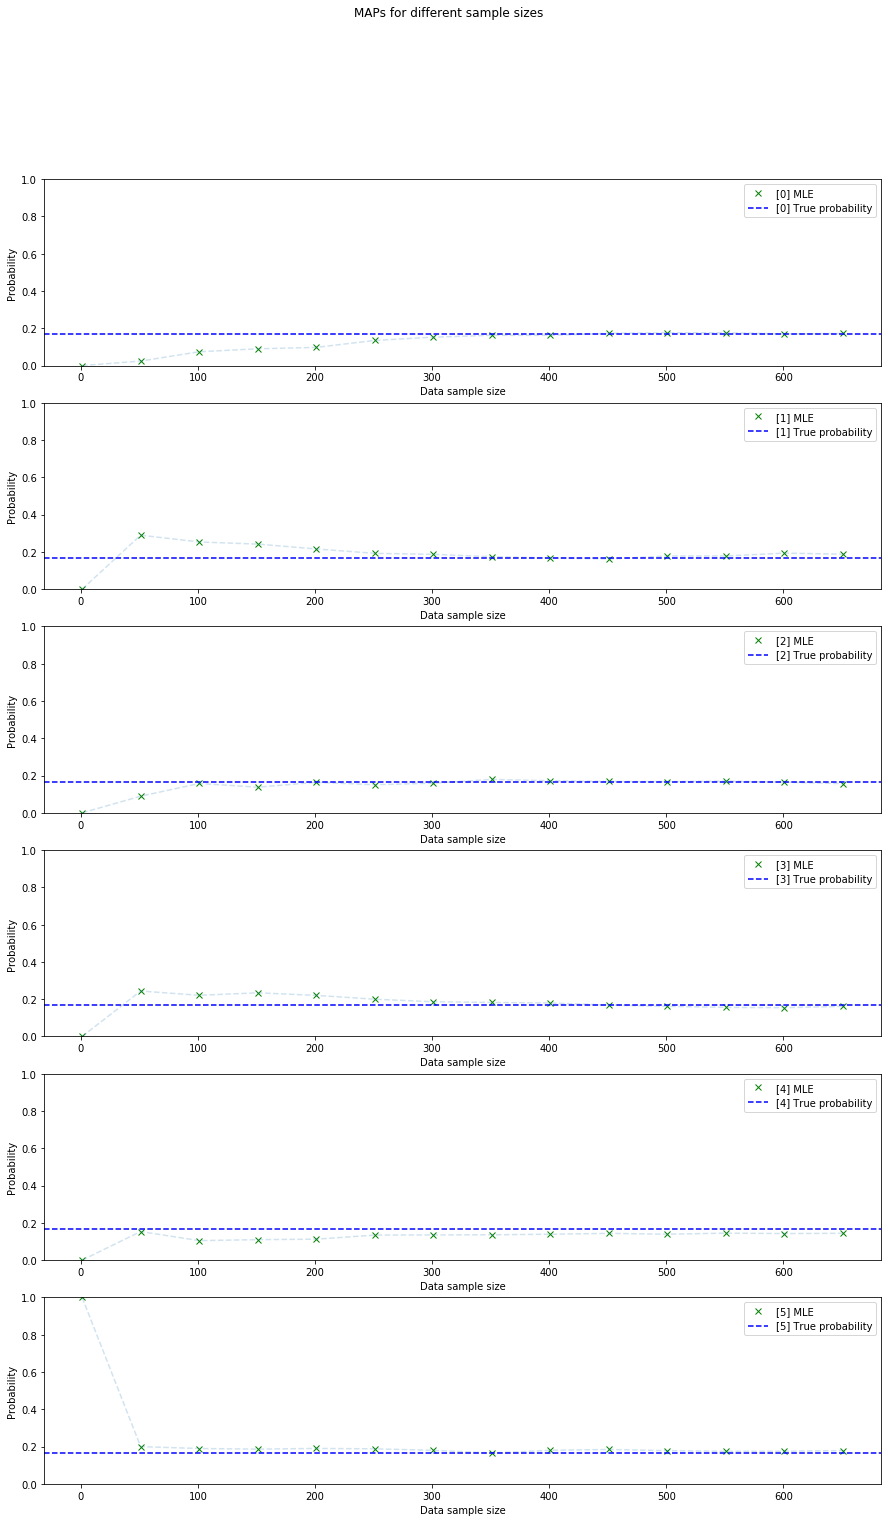

In [37]:
# "Near" prior
map_utils.plot_map_estimate_given_sample_size(
    prior_model_cls=lambda: DiceRollingPrior(alpha=[0.1,0.3,0.1,0.2,0.05,0.16]), # fill with arguments for prior
    lk_model_cls=DiceRollingLikelihood,
    data=dice_data,
    true_prob=true_sides_probs,
    step=50,
    epochs_per_step=200,
)

C:\Studia\PUMA\l03-monday19-BlonskiP\src\mm\map_.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float)


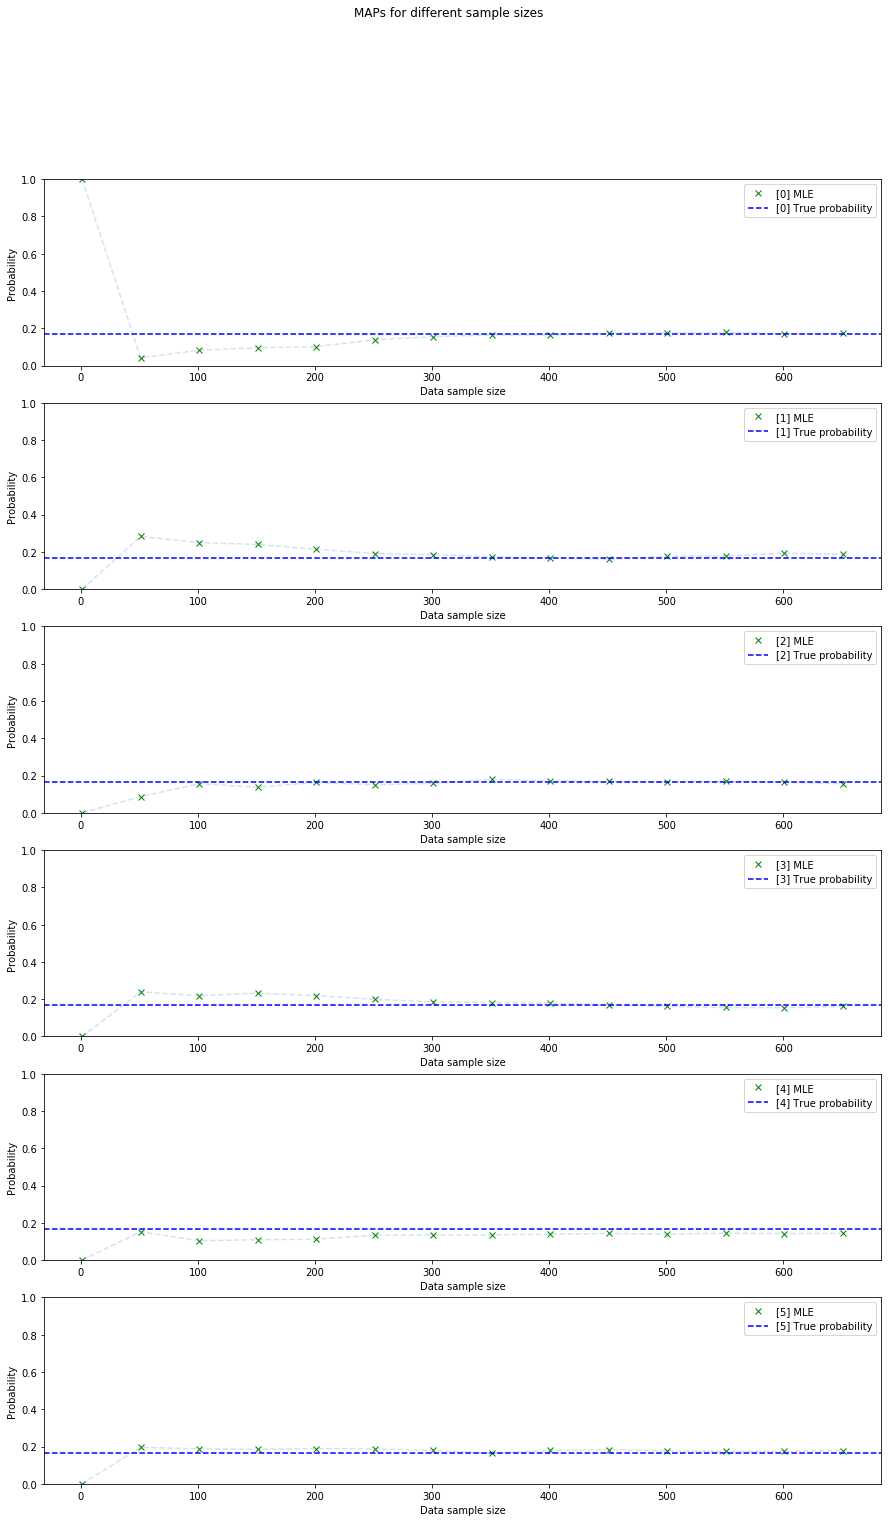

In [38]:
# "Different" prior
map_utils.plot_map_estimate_given_sample_size(
    prior_model_cls=lambda: DiceRollingPrior(alpha=[0.9,0.02,0.02,0.02,0.02,0.02]), # fill with arguments for prior
    lk_model_cls=DiceRollingLikelihood,
    data=dice_data,
    true_prob=true_sides_probs,
    step=50,
    epochs_per_step=200,
)